# Azure ML demonstration : experimentation

                                     

In [67]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
import matplotlib.image as mpimg
from skimage.io import imread, imshow
from sklearn.metrics import confusion_matrix, accuracy_score

In [68]:
# Removing warnings for deprecated features etc
import warnings
warnings.filterwarnings("ignore")

## Set up Azure ML workspace connection 

In [69]:
from arcus.azureml.environment.aml_environment import AzureMLEnvironment
from arcus.ml.images import explorer

In [75]:
training_name = 'mnist-logistic-regression'
experiment_name = 'ml-conf-munich'

In [71]:
azure_config_file = '.azureml/config.json'
aml = AzureMLEnvironment.Create(config_file=azure_config_file)

Connected to AzureML workspace
>> Name: savanh-time-travel
>> Subscription: b73995e3-caad-4882-8644-f2175789c3ff
>> Resource group: savanh-time-travel


## MNIST classification
De MNIST ("Modified National Institute of Standards and Technology") is a dataset that is being used a lot to measure and benchmark different classification algorithms.  The dataset contains 10's thousands of images of handwritten numbers.  More information can be found here: http://yann.lecun.com/exdb/mnist/


### Load data

In [8]:
aml_df = aml.load_tabular_dataset('mnist')


In [72]:
aml_df.shape

(42000, 785)

In [10]:
training_set_size = 1000
test_set_size = 250
scoring_parameter = "accuracy"
decision_function_shape = "ovr"

df = aml_df.copy()

In [11]:
#Inlezen van de dataset en de trainingsgrootte bepalen
if(training_set_size > 0 and test_set_size > 0):
    df = df.sample(n=training_set_size + test_set_size)

y = df.label.values # The label is what we should predict = the y in the equation
X = np.asarray(df.drop(['label'],axis=1))


In [12]:
if test_set_size <= 0: 
    test_set_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=42)

In [13]:
print(f'Train records: {len(X_train)}')
print(f'Test records: {len(X_test)}')
print(f'Input features: {X_train.shape[1]}')

Train records: 1000
Test records: 250
Input features: 784


## Data demonstration

2


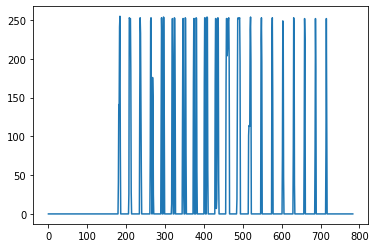

In [14]:
sample_image = X[31].reshape(28,28)

print(y[30])
plt.plot(X[1])
plt.show()

In [15]:
str_array = ''
for b in X[2]:
    str_array += f'{b},'

print(str_array)

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,141,255,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,118,251,253,154,0,0,41,87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66,253,253,249,90,0,49,225,177,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,194,253,242,107,0,0,116,253,253,159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,69,241,253,171,0,0,0,116,253,253,223,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,235,253,253,33,0,0,0,116,253,253,253,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,140,253,253,167,3,0,0,14,191,253,253,253,106,0,0,0,0,0,0,0,0,0,0,0,0,0,9,145,249,253,236,72,65,72,230,232,253,253,253,253,106,0,0,0,0,0,0,0,0,0,0,0,0,0,33,253,253,253,228,156,250,253,253,253,253,253,253,253,106,0,0,0,0,0,0,0,0,0,0,0,0,35,211,253,253,253,253,253,253,253,253,253,253,253,25

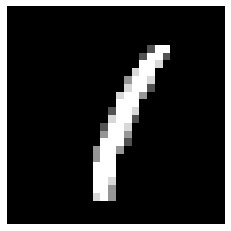

In [16]:
explorer.show_image(sample_image)

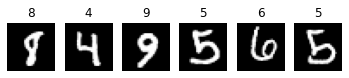

In [73]:
explorer.visualize_classes(X_train.reshape(len(X_train),28,28), y_train, image_count=6)

## Data preparation (scaling)

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

## Model training, local

In [76]:
trainer = aml.start_experiment(experiment_name)

In [77]:
c_value = 0.21
_run = trainer.new_run(f'C={c_value}')
model = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', C=c_value)
model.fit(X_train, y_train)


LogisticRegression(C=0.21, class_weight='balanced', multi_class='multinomial')

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        28
           1       0.93      0.97      0.95        29
           2       0.88      0.75      0.81        20
           3       0.85      1.00      0.92        22
           4       0.88      0.88      0.88        24
           5       0.97      0.81      0.88        37
           6       0.96      0.92      0.94        26
           7       0.86      0.90      0.88        20
           8       0.89      0.84      0.86        19
           9       0.83      1.00      0.91        25

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250

[[26  0  0  1  0  0  1  0  0  0]
 [ 0 28  0  0  0  0  0  0  1  0]
 [ 1  1 15  0  2  0  0  0  0  1]
 [ 0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0 21  0  0  1  0  2]
 [ 1  0  1  2  0 30  0  2  0  1]
 [ 0  0  0  0  0  1 24  0  1  0]
 [ 0  0  1

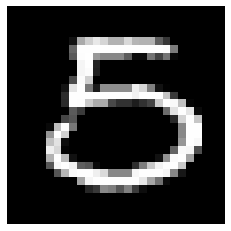

In [78]:
trainer.evaluate_image_classifier(model, X_test=X_test, y_test=y_test, failed_classifications_to_save=3, image_shape=(28,28), finish_existing_run = False, upload_model=False, save_curves_as_image=False)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        28
           1       0.85      0.97      0.90        29
           2       0.79      0.75      0.77        20
           3       1.00      0.91      0.95        22
           4       0.88      0.88      0.88        24
           5       0.91      0.81      0.86        37
           6       0.96      0.85      0.90        26
           7       0.86      0.90      0.88        20
           8       0.88      0.79      0.83        19
           9       0.81      1.00      0.89        25

    accuracy                           0.88       250
   macro avg       0.89      0.88      0.88       250
weighted avg       0.89      0.88      0.88       250

[[27  0  0  0  0  0  0  1  0  0]
 [ 0 28  0  0  0  0  0  0  1  0]
 [ 1  1 15  0  1  0  1  0  0  1]
 [ 0  0  1 20  0  1  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  3]
 [ 1  2  1  0  1 30  0  1  0  1]
 [ 0  1  0  0  0  2 22  0  1  0]
 [ 0  0  1

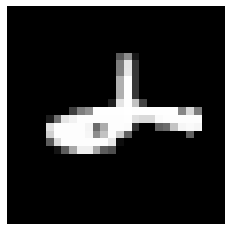

In [79]:
for c_value in [0.01, 1, 5] :
    _run = trainer.new_run(f'C={c_value}')
    model = LogisticRegression(solver='saga', C=c_value)
    model.fit(X_train, y_train)
    trainer.evaluate_image_classifier(model, X_test=X_test, y_test=y_test, failed_classifications_to_save=3, image_shape=(28,28), finish_existing_run = True, upload_model=True, save_curves_as_image=False)
    #trainer.evaluate_classifier(model, X_test, y_test, upload_model = True)

## Model training, docker

In [80]:
trainer = aml.start_experiment(experiment_name)
trainer.setup_training(training_name)

In [81]:
args = {
    '--c_value': 1.92,
    '--solver': 'lbfgs', # lbfgs newton-cg liblinear saga sag
    '--train_test_split_ratio': 0.25
}

compute_run = trainer.start_training(training_name, environment_type=None, 
                       script_parameters=args, use_estimator=True,
                       compute_target='gpu-training', gpu_compute=True)

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/ml-conf-munich/runs/ml-conf-munich_1624351055_f22aed1b?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [82]:
for solver in ['lbfgs', 'newton-cg']:
    for c_value in np.logspace(0.001, 2, num=3):
        args = {
            '--c_value': c_value,
            '--solver': solver, # lbfgs newton-cg liblinear saga sag
            '--train_test_split_ratio': 0.3
        }


        compute_run = trainer.start_training(training_name, environment_type=None, 
                               script_parameters=args, use_estimator=True,
                               compute_target='gpu-training', gpu_compute=True)

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/ml-conf-munich/runs/ml-conf-munich_1624351073_35d65320?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/ml-conf-munich/runs/ml-conf-munich_1624351075_1cd14f0d?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/ml-conf-munich/runs/ml-conf-munich_1624351077_cceab95e?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/ml-conf-munich/runs/ml-conf-munich_1624351079_a899478d?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/ml-conf-munich/runs/ml-conf-munich_1624351080_03d5c8be?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/ml-conf-munich/runs/ml-conf-munich_1624351082_a0908b35?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Deploy ML Model

In [53]:
model_name = 'mnist'

In [54]:
from azureml.core import Run

def deploy_model(experiment, run_number, model_location):
    for run in experiment.get_runs():
        if run.number == run_number:
            model = run.register_model(model_name=model_name,
                         `  tags={'output': 'number', 'input': 'mnistarray'},
                           model_path=model_location)
            print(model.name, model.id, model.version, sep='\t')
            break
    
deploy_model(trainer._AzureMLTrainer__experiment, 6, 'outputs/model.sav')

WARNING - Run Number's semantics may be modified in the future


mnist	mnist:5	5


In [55]:
from azureml.core.model import Model
series_model = Model.list(aml.get_azureml_workspace(), name=model_name, latest=True)[0]
print(series_model)

Model(workspace=Workspace.create(name='savanh-time-travel', subscription_id='b73995e3-caad-4882-8644-f2175789c3ff', resource_group='savanh-time-travel'), name=mnist, id=mnist:5, version=5, tags={'output': 'number', 'input': 'mnistarray'}, properties={})


In [59]:
Model.get_model_path(training_name)

'mnist-logistic-regression'

## Set up inference cluster

In [60]:
web_service_name= training_name.lower() + '-v1'

In [63]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import Model

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1, 
                                                       auth_enabled=True, enable_app_insights=True)
deployment_target = None

In [64]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
myenv = Environment.get(aml.get_azureml_workspace(), 'logistic-regression')
inference_config = InferenceConfig(entry_script=training_name + '/score.py', environment=myenv)

In [66]:
from azureml.core import Environment
from azureml.core.webservice import Webservice
from azureml.exceptions import ComputeTargetException, WebserviceException

try:
    service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())
    print('Web service exists and retrieved')
except WebserviceException:
    print('Deploying model as web service')
    service = Model.deploy(workspace=aml.get_azureml_workspace(), 
                           name=web_service_name, 
                           models=[series_model], 
                           deployment_target=deployment_target,
                           inference_config=inference_config, 
                           deployment_config=deployment_config)
    service.wait_for_deployment(show_output=True)
    print(service.state)
    service.get_logs()    
    print('Web service created')

Web service exists and retrieved


## Update scoring script

In [48]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
print(training_name)
myenv = Environment.get(aml.get_azureml_workspace(), 'logistic-regression')
inference_config = InferenceConfig(entry_script=training_name + '/score.py', environment=myenv)

mnist-logistic-regression


In [49]:
from azureml.core import Environment
from azureml.core.webservice import Webservice

service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())

In [50]:
from azureml.core.model import Model
series_model = Model.list(aml.get_azureml_workspace(), name=experiment_name, latest=True)[0]
print(series_model)

Model(workspace=Workspace.create(name='savanh-time-travel', subscription_id='b73995e3-caad-4882-8644-f2175789c3ff', resource_group='savanh-time-travel'), name=ml-conf, id=ml-conf:1, version=1, tags={'output': 'number', 'input': 'mnistarray'}, properties={})


In [99]:
service.update(models=[series_model], inference_config=inference_config, enable_app_insights=True)

In [100]:
service.wait_for_deployment(show_output=True)

Running..................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
